In [1]:
import os
import mat73
import numpy as np
import pandas as pd
import time
import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from imblearn.under_sampling import RandomUnderSampler
np.random.seed(0)

In [2]:

def load_dataframe():
    current_directory = os.getcwd()
    file_path = os.path.join(os.path.dirname(current_directory), 'spect_phee2monkey_mel_cell_nopadding_streched_50x50.mat')
    data_dict = mat73.loadmat(file_path)
    data_dict["spect"] = [data_dict["spect"][:, :, i] for i in range(data_dict["spect"].shape[2])]
    df = pd.DataFrame(data_dict)
    for name in ['callee', 'caller', 'expname']:
        df[name] = df[name].apply(lambda x: x[0])
    df.loc[df["callee"] == "Brhama", "callee"] = "Brahma"
    df.loc[df["caller"] == "Brhama", "caller"] = "Brahma"
    dates_str = df["expname"].astype("string").apply(lambda x: x.replace("exp_", "")[:10])
    df["date"] = pd.to_datetime(dates_str, format='%Y_%m_%d')
    return df

In [137]:
def show_cm(cmn,title,labels,average_oob_score,to_save = False, directory_to_save_in = None):
    fig, ax = plt.subplots(figsize=(15,15))
    f = sns.heatmap(cmn, annot=True, fmt=".1%", linewidths=1.0, square=1)
    plt.title(title +f"\nAverage oob Score {round(average_oob_score,3)} ", fontsize=25)
    plt.xlabel('Predicted Label', fontsize=20)
    plt.ylabel('True Label', fontsize=20)
    _ = ax.set_xticklabels(labels)
    _ = plt.xticks(rotation=70)
    _ = ax.set_yticklabels(labels)
    _ = plt.yticks(rotation=0)

    if to_save:
        if not os.path.exists(directory_to_save_in):
            os.makedirs(directory_to_save_in)
        plt.savefig(directory_to_save_in+f"/{title}.pdf",format='pdf')

In [3]:
df= load_dataframe()

87.66381192207336


In [ ]:
df = df[df['caller'] != 'Chaos']

In [132]:
def create_derivative_max_signal_amplitude_df(df, make_derivative = True, max_signal=True, make_amplitude=True):

    column_names = ['callee','caller','expname','date']
    if make_derivative:
        column_names.extend([f"diff_{x}" for x in(range(1,50))])
    if max_signal:
        column_names.extend(f"max_signal_{x}" for x in range(1,51))
    if make_amplitude:
        column_names.extend(f"amplitude_{x}" for x in range(1,51))
    exp_dict= {}

    counter = 0
    for exp in tqdm.tqdm(df.iterrows()):

        exp_info_series = pd.Series([exp[1]["callee"],exp[1]["caller"],exp[1]["expname"],exp[1]["date"]])
        max_row_indices = np.argmax(exp[1]["spect"],axis=0)
        exp_derivatives = pd.Series(np.diff(max_row_indices))
        exp_amplitudes = pd.Series(np.amax(exp[1]["spect"],axis=0))
        # make features
        if make_derivative:
            exp_info_series = exp_info_series.append(exp_derivatives,ignore_index=True)
        if max_signal:
            exp_info_series = exp_info_series.append(pd.Series(max_row_indices),ignore_index=True)
        if make_amplitude:
            exp_info_series = exp_info_series.append(exp_amplitudes,ignore_index=True)

        exp_info_series.index = column_names

        #using dict for fast adding speed
        exp_dict[counter] = exp_info_series
        counter +=1

    return pd.DataFrame.from_dict(exp_dict,orient='index')



In [131]:
df_derivative = create_derivative_max_signal_amplitude_df(df)

,callee,caller,expname,date,diff_1,diff_2,diff_3,diff_4,diff_5,diff_6,...,amplitude_41,amplitude_42,amplitude_43,amplitude_44,amplitude_45,amplitude_46,amplitude_47,amplitude_48,amplitude_49,amplitude_50
0,Dionysus,Dia,exp_2021_08_18_001,2021-08-18,0,2,1,2,1,1,...,0.903601,0.971084,0.947209,0.910538,0.941693,0.921833,0.852689,0.851279,0.859138,0.829171
1,Dionysus,Dia,exp_2021_08_18_001,2021-08-18,2,2,1,1,2,-1,...,0.913526,0.907195,0.893230,0.918006,0.919830,0.850912,0.787923,0.678478,0.725555,0.704285
2,Dionysus,Dia,exp_2021_08_18_001,2021-08-18,0,0,0,-1,0,0,...,0.952437,0.947603,0.969109,0.996860,0.971738,0.909762,0.827730,0.823097,0.769001,0.656980
3,Dia,Dionysus,exp_2021_08_18_001,2021-08-18,0,0,0,0,0,1,...,0.958798,0.989482,0.980762,0.955377,0.944534,0.953832,0.952182,0.934606,0.897829,0.922279
4,Dionysus,Dia,exp_2021_08_18_001,2021-08-18,0,4,3,1,2,1,...,0.878060,0.849161,0.843800,0.839534,0.794232,0.769835,0.774466,0.731469,0.665236,0.703016
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48007,Bhumi,Ella,exp_2023_03_20_002,2023-03-20,1,3,5,2,2,1,...,0.881510,0.902426,0.862178,0.787505,0.862576,0.859496,0.731601,0.666608,0.639386,0.594562
48008,Bhumi,Ella,exp_2023_03_20_002,2023-03-20,4,4,3,-1,2,2,...,0.853977,0.813911,0.881829,0.858193,0.834707,0.803656,0.795642,0.695224,0.658132,0.616240
48009,Ella,Bhumi,exp_2023_03_20_002,2023-03-20,0,3,3,2,1,1,...,0.832841,0.795719,0.806810,0.827893,0.777362,0.793525,0.734662,0.670560,0.644267,0.609684
48010,Bhumi,Ella,exp_2023_03_20_002,2023-03-20,2,3,2,1,1,1,...,0.893355,0.870321,0.876044,0.824048,0.822617,0.781402,0.738909,0.666457,0.619383,0.553709


In [102]:
def pred_caller_to_collees_train_test(df, caller_label, callees_to_drop = [], repeat_amount = 100):
    df_caller = df[df["caller"] == caller_label].drop(columns="caller")
    df_caller = df_caller[~df_caller["callee"].isin(callees_to_drop)]
    X, y = df_caller.drop(columns="callee"),df_caller["callee"]
    labels = y.unique()
    cm_list = []
    oob_score_ls = []
    rus = RandomUnderSampler()
    rfc = RandomForestClassifier(oob_score=True)
    for i in tqdm.tqdm(range(repeat_amount)):
        X_resampled, y_resampled = rus.fit_resample(X,y)
        rfc.fit(X_resampled,y_resampled)
        oob_score = rfc.oob_score_
        y_pred = rfc.classes_[np.argmax(rfc.oob_decision_function_,axis=1)]
        cm = confusion_matrix(y_true=y_resampled, y_pred=y_pred, labels=np.unique(y))
        cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm_list.append(cmn)
        oob_score_ls.append(oob_score)
    return np.mean(cm_list, axis=0), np.mean(oob_score_ls), labels

In [146]:
directory_to_save_in = "Callers Callee Predictions Using Max Signal, Derivative & Amplitude"

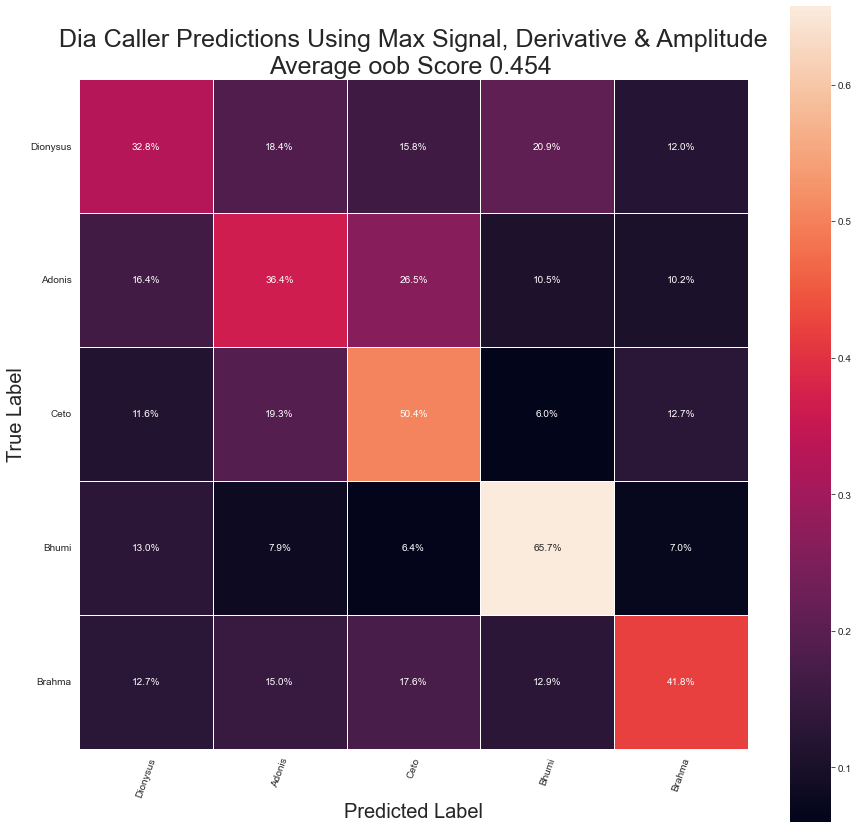

In [147]:
cmn, oob_score,labels =  pred_caller_to_collees_train_test(df_derivative.drop(columns=["expname","date"]),'Dia',['Ella'])
title = "Dia Caller Predictions Using Max Signal, Derivative & Amplitude"
show_cm(cmn,title,labels,oob_score,True,directory_to_save_in)

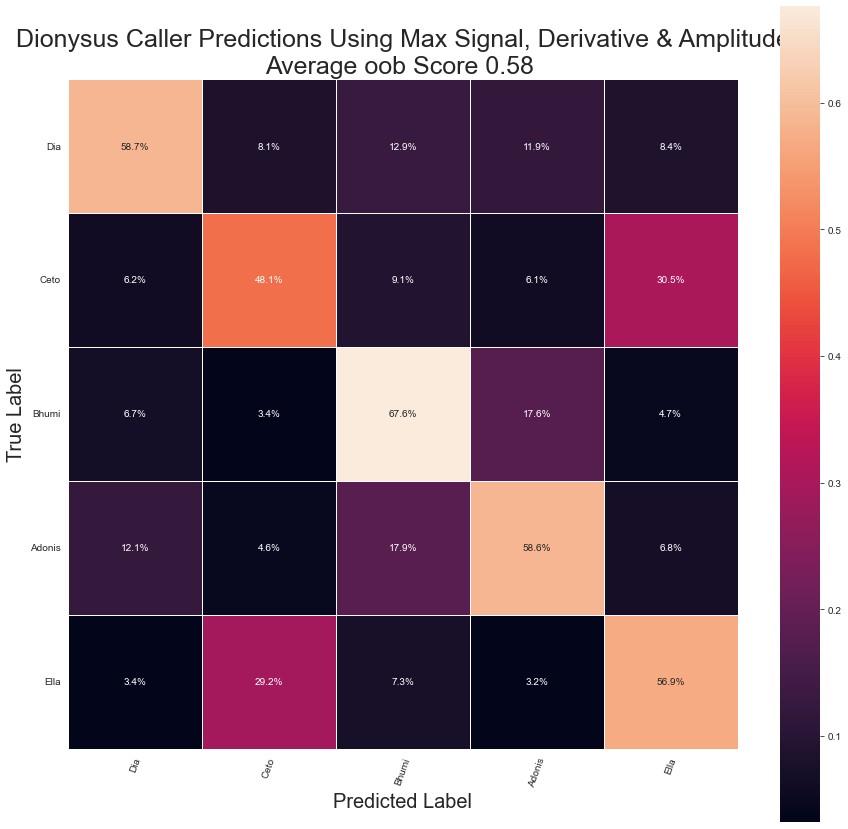

In [148]:
cmn_dio, oob_score_dio,labels_dio =  pred_caller_to_collees_train_test(df_derivative.drop(columns=["expname","date"]),"Dionysus", ["Brahma", "Chaos"])
title_dio = "Dionysus Caller Predictions Using Max Signal, Derivative & Amplitude"
show_cm(cmn_dio,title_dio,labels_dio,oob_score_dio,True,directory_to_save_in)

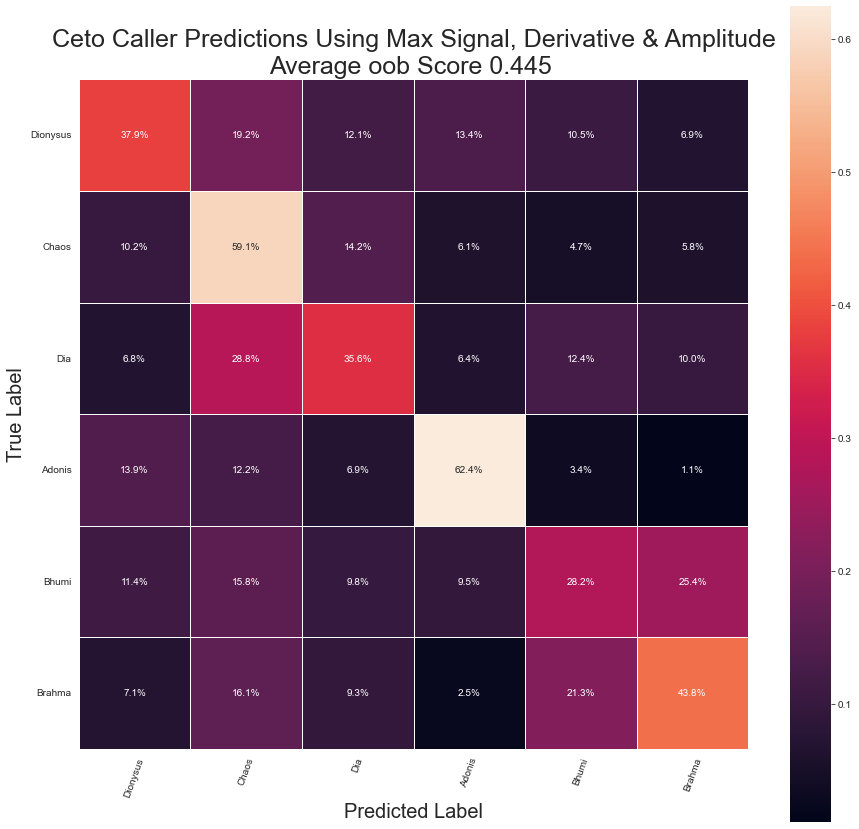

In [149]:
cmn_ceto, oob_score_ceto,labels_ceto =  pred_caller_to_collees_train_test(df_derivative.drop(columns=["expname","date"]),"Ceto")
title_ceto = "Ceto Caller Predictions Using Max Signal, Derivative & Amplitude"
show_cm(cmn_ceto,title_ceto,labels_ceto,oob_score_ceto,True,directory_to_save_in)

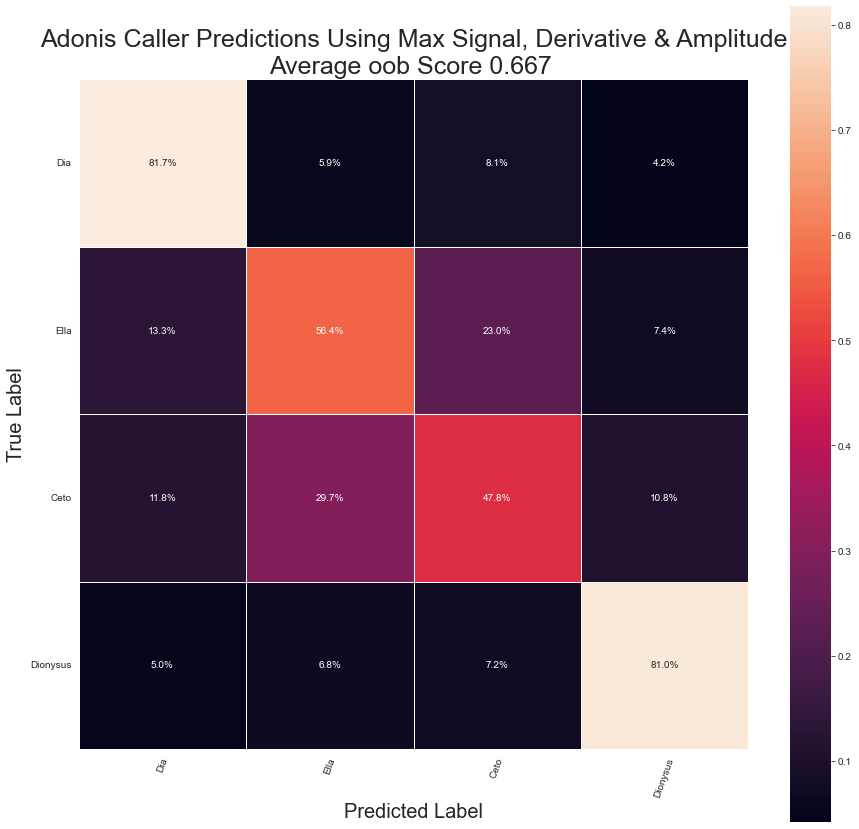

In [150]:
cmn_adonis, oob_score_adonis,labels_adonis =  pred_caller_to_collees_train_test(df_derivative.drop(columns=["expname","date"]),"Adonis")
title_adonis = "Adonis Caller Predictions Using Max Signal, Derivative & Amplitude"
show_cm(cmn_adonis,title_adonis,labels_adonis,oob_score_adonis,True,directory_to_save_in)

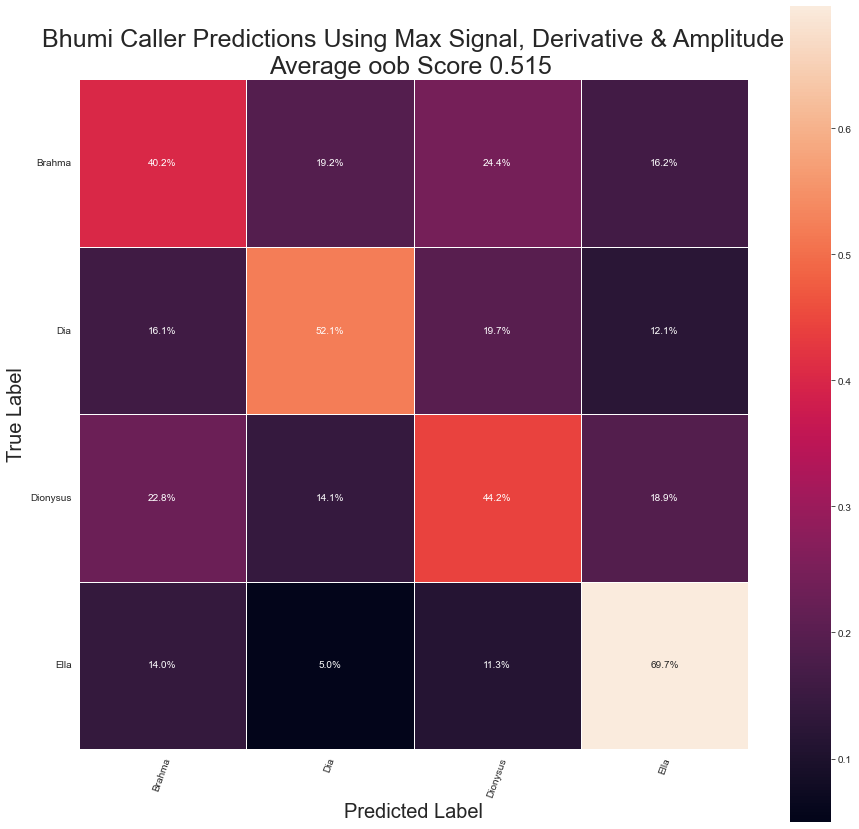

In [151]:
cmn_bhumi, oob_score_bhumi,labels_bhumi =  pred_caller_to_collees_train_test(df_derivative.drop(columns=["expname","date"]),"Bhumi", ["Adonis", "Ceto"])
title_bhumi = "Bhumi Caller Predictions Using Max Signal, Derivative & Amplitude"
show_cm(cmn_bhumi,title_bhumi,labels_bhumi,oob_score_bhumi,True,directory_to_save_in)

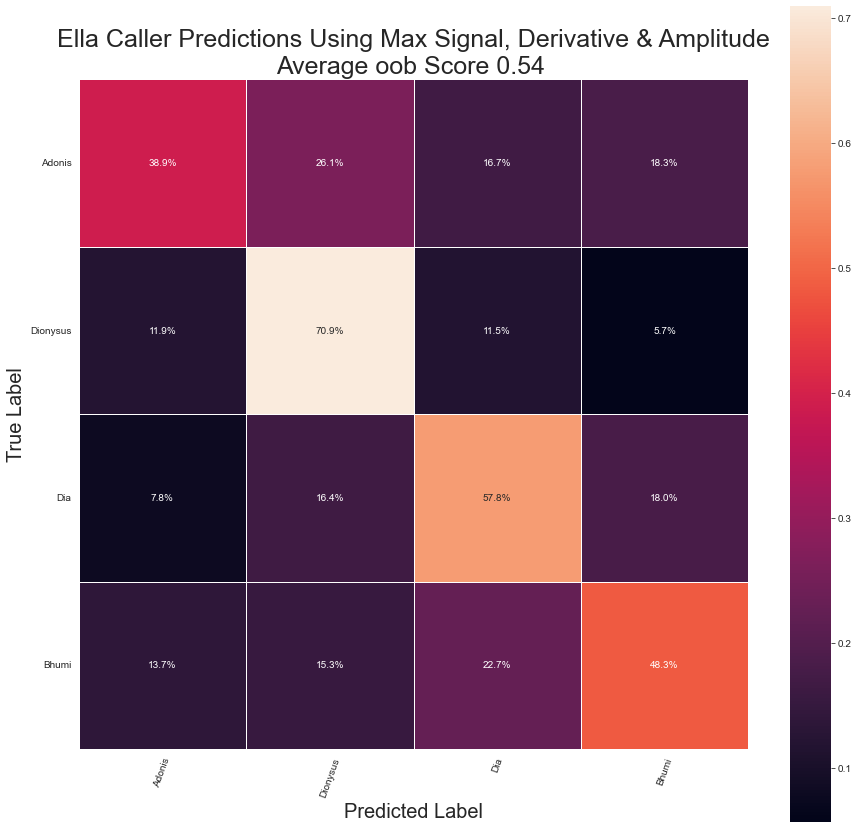

In [152]:
cmn_ella, oob_score_ella,labels_ella =  pred_caller_to_collees_train_test(df_derivative.drop(columns=["expname","date"]),"Ella")
title_ella = "Ella Caller Predictions Using Max Signal, Derivative & Amplitude"
show_cm(cmn_ella,title_ella,labels_ella,oob_score_ella,True,directory_to_save_in)